# Read and analysis slow control data version 2


Updated June 10th 20204

Starting with headers, envorimental varibles, and functions

In [3]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob,os,platform



#varible for determining the lab pc or other pc, Check if windows or not, then try to grab pc name
pcname=""
if platform.system() == "Windows":
    pcname=platform.uname().node
else:
    try:
        pcname=os.uname()[1]
    except:
        print("Issue with finding pc name")

env_var_dataloc ="" #varible for location of waveform data. 
data_dir_mod_old="" #varible for small difference in storage managment between pc 1 and 2
if pcname=='PHYS-PSB02802': #Lab pc 2, (Labview pc)
    env_var_dataloc ="A:/DATA/"
    
elif pcname=="PHYS-PSB02801": #Lab pc 1, (solidworks pc)
    env_var_dataloc ="data/" #This is true for Jason's work atm (June 10th) Needs Updateing to global or user friendly verison
    data_dir_mod_old="/"


## Functions and def

#### h5 file info

In [45]:
groups = []
datasets = []
atts = {} # attributes

def gather_names_and_atts(name, obj):
    if isinstance(obj, h5py.Group):
        groups.append(name)
    elif isinstance(obj, h5py.Dataset):
        datasets.append(name)
    for key, val in obj.attrs.items():
        atts[name + '/' + key] = val

def list_groups_datasets_atts(file):
    with h5py.File(file, 'r') as f:
        f.visititems(gather_names_and_atts)

def print_lists(list_name):
    i = 0
    for name in list_name:
        print(i, name)
        i=i+1
    print()

def create_dataframe_from_datasets(file_name, dataset_names):

    with h5py.File(file_name, 'r') as f:
        dataset_names =[]
       
        for i in f.keys():
            for j in f[i].keys():
                dataset_names.append(i+"/"+j)
       
        
        dfs = {name: pd.DataFrame(f[name][:])   for name in dataset_names }
    return dfs


def poop():
    with h5py.File(file_name, 'r') as f:
        for name in dataset_names:
            try:
                dfs = {name: pd.DataFrame(f[name][:]) }
            except:
                print("issue with", name)
    return dfs

## Read in file and make dataframe function

In [16]:
channel_list=  ["Flow_Meter" ,"Liquid_Nitro_Valve", "PID_Heater","Pressure_1","Pressure_2",
                "Heater_State","Nitro_Baseline","Nitro_Weigth","Target_Channel","Target_Temperature",
                "Time","Valve_State","Cold_Finger","Nitro_Reservoir","Xe_Cell_1","Xe_Cell_2",
                "Xe_Cell_3","Xe_Cell_Outside","Pressure_Cell","Pressure_Mfold","Storage_1","Storage_2",
                "Pressure_Cryostat","Pressure_Manifold","Pressure_Nitro","Cryostat_Top","Xe_Cell_Bottom","Xe_Cell_Top"]


def getprologue_time(f):
    ''' Argument f == hdf5 file
        returns dict of time information 
    '''
    atr="Prologue"
    prologue=f.attrs[atr]
    prologue=prologue.replace("\r","")
    splitlog=prologue.split( "\n")
    timeinfostr=splitlog[2]
    timeinfo={}
    timeinfo["year"]=int(timeinfostr[0:4])
    timeinfo["mon"]=int(timeinfostr[4:6])
    timeinfo["day"]=int(timeinfostr[6:8])
    timeinfo["hour"]=int(timeinfostr[8:10])
    timeinfo["min"]=int(timeinfostr[10:12])
    timeinfo["sec"]=int(timeinfostr[12:14])
    return timeinfo

def timetosecs(timeinfo):
    '''argument timeinfo dict 
    returns total seconds '''
    return timeinfo["hour"]*60*60 +timeinfo["min"]*60+timeinfo["sec"]



def calib_dict_wtime(file_name):

    fh5= h5py.File(file_name, 'r') 
    timeinfo=getprologue_time(fh5)
    timeoffset=timetosecs(timeinfo)
    print("Time offset",timeoffset)
    fh5.close()
    list_groups_datasets_atts(file_name)
    dataset_names = datasets # to create a dataframe for each
    datadict = create_dataframe_from_datasets(file_name, dataset_names)
    newdict={}
    l,m,n=-1,-1,-1
    j=0
    js=[-1,-1,-1]
    print(datadict.keys())
    for key in datadict.keys():

        #print(key)
        pos=key.find("/")
        group=key[:pos]
        if group=="omb_daq":
            j=0
            l+=1
            js[0]+=1
        elif group=="pid_info":
            j=1
            m+=1
            js[1]+=1
        elif group=="tc08_daq":
            j=2
            n+=1
            js[2]+=1
        
        m,b=1,0
        s_key=key[pos+1:]

        if s_key =="Pressure_1":
            s_key="Pressure_Cell"
        elif s_key =="Pressure_2":
            s_key="Pressure_Manifold"
        if s_key not in channel_list:
            
           print("Not in channel list " ,s_key)
           # continue

        if s_key=="Inter" or s_key =="Slope":
                continue
        
        else:
            
            #print(group,key, js[j])
            if j==1:
                m,b=1,0
            else:
                try:
                    m = datadict["%s/Slope"%(group)][0][js[j]]
                    b = datadict["%s/Inter"%(group)][0][js[j]]
                except:
                    m,b=1,0
        
            
        #print(m,b, )
        
        newdict[s_key]=datadict[key][0]*m +b
    
    try:
        newdict["Time"] = timeoffset + np.arange(0,len(newdict["Time"]))*2
    except:
        newdict["Time"] = timeoffset + np.arange(0,len(newdict[s_key]))*2

    return newdict



def get_slow_ctr_df(filedate):

    filedes ="slow_control"
    datadir="./data"
    
    try:
        filedate=str(filedate)
    except:
        print("Issue with file date")

    filelist=glob.glob("%s/%s*.h5"%(datadir,filedate))
    print(filelist)
    if len(filelist) <1:
        print("Error with globing files")

    datadicts=[]
    DFs=[]
    for filename in filelist:
      
        finfo=os.stat(filename)
        print(finfo.st_size)
        if finfo.st_size < 18000:
            print("Skipping %s due to size"%(filename))
            continue
        datasets = []
        print(filename)
        datadict=calib_dict_wtime(filename)
        datadicts.append(datadict)
        try:
            DFs.append(pd.DataFrame.from_dict(datadict))
        except:
            print("issue with appending files into list")
        print( "len",len(datadict["Time"]))

    DF = pd.concat(DFs)
    DF =DF.sort_values(by=["Time"])

    return DF

## Read slowcontrol data - from 20231110

In [24]:
filedate="20240520"
filedes ="slow_control"
datadir =env_var_dataloc

filelist=glob.glob("%s%s*.h5"%(datadir,filedate))

print(filelist)

datadicts=[]
DFs=[]
for filename in filelist:
    datasets = []
    print(filename)
    datadict=calib_dict_wtime(filename)
    datadicts.append(datadict)
    print( "len",len(datadict["Time"]))
    if len(datadict) >=4:
        DFs.append(pd.DataFrame.from_dict(datadict))
    else:
        print(len(pd.DataFrame.from_dict(datadict)), type(pd.DataFrame.from_dict(datadict)))

    







['A:/DATA\\20240520_slow_control.h5', 'A:/DATA\\20240520_slow_control_1.h5', 'A:/DATA\\20240520_slow_control_10.h5', 'A:/DATA\\20240520_slow_control_2.h5', 'A:/DATA\\20240520_slow_control_3.h5', 'A:/DATA\\20240520_slow_control_4.h5', 'A:/DATA\\20240520_slow_control_5.h5', 'A:/DATA\\20240520_slow_control_6.h5', 'A:/DATA\\20240520_slow_control_7.h5', 'A:/DATA\\20240520_slow_control_8.h5', 'A:/DATA\\20240520_slow_control_9.h5']
A:/DATA\20240520_slow_control.h5
Time offset 33469
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inter', 'omb_daq/Liquid_Nitro_Valve', 'omb_daq/PID_Heater', 'omb_daq/Pressure_Cryostat', 'omb_daq/Pressure_Manifold', 'omb_daq/Pressure_Nitro', 'omb_daq/Slope', 'pid_info/Heater_State', 'pid_info/Nitro_Baseline', 'pid_info/Nitro_Weigth', 'pid_info/Target_Channel', 'pid_info/Target_Temperature', 'pid_info/Time', 'pid_info/Valve_State', 'tc08_daq/Cold_Finger', 'tc08_daq/Cryostat_Top', 'tc08_daq/Inter', 'tc08_daq/Nitro_Reservoir', 'tc08_daq/Slope', 'tc08_daq/Storage_1', 'tc08_

ValueError: array length 0 does not match index length 1

{'Flow_Meter': 0        0.001879
 1        0.001832
 2        0.001666
 3        0.001709
 4        0.001470
            ...   
 63696    0.001629
 63697    0.001448
 63698    0.001731
 63699    0.001675
 63700    0.001734
 Name: 0, Length: 63701, dtype: float64,
 'Liquid_Nitro_Valve': 0        0.0
 1        0.0
 2        0.0
 3        0.0
 4        0.0
         ... 
 63696    0.0
 63697    0.0
 63698    0.0
 63699    0.0
 63700    0.0
 Name: 0, Length: 63701, dtype: float64,
 'PID_Heater': 0        0.0
 1        0.0
 2        0.0
 3        0.0
 4        0.0
         ... 
 63696    0.0
 63697    0.0
 63698    0.0
 63699    0.0
 63700    0.0
 Name: 0, Length: 63701, dtype: float64,
 'Pressure_Cryostat': 0        4.585524
 1        4.585149
 2        4.585608
 3        4.585421
 4        4.587227
            ...   
 63696    6.570799
 63697    6.569961
 63698    6.570638
 63699    6.570001
 63700    6.570621
 Name: 0, Length: 63701, dtype: float64,
 'Pressure_Manifold': 0         9.85228

In [76]:

def Get_dict_from_hdf5(file_name):
    with h5py.File(file_name, 'r') as f:
        dataset_names =[]
        
        for i in f.keys():
            for j in f[i].keys():
                dataset_names.append(i+"/"+j)
        
        
        dfs = {name: pd.DataFrame(f[name][:])   for name in dataset_names }

    return dfs

In [90]:
f = h5py.File(file,'r')
for i in f.keys():
    for j in f[i].keys():
        print(f[i+"/"+j][:])
        break

[0.00148535 0.00168085 0.00175714 ... 0.00133562 0.0014286  0.00177336]
[0. 0. 0. ... 0. 0. 0.]
[250.96560669 250.94921875 250.95332336 ... 289.03579712 289.03234863
 289.02877808]


## Read slowcontrol data - from 20240606

In [124]:
date=20240605
data_loc=env_var_dataloc
search_term=data_loc+str(date)+"*"
file_list=glob.glob(search_term)
date=20240606
data_loc=env_var_dataloc
search_term=data_loc+str(date)+"*"
file_list =file_list + glob.glob(search_term)
print(file_list)

slowcontrol_dict_list=[]

for file in file_list:
    if os.path.getsize(file) <=40000:
        continue
    slowcontrol_dict_list.append(pd.DataFrame.from_dict(calib_dict_wtime(file)))
DF_June06=pd.concat(slowcontrol_dict_list)



['A:/DATA\\20240605_slow_control.h5', 'A:/DATA\\20240605_slow_control_1.h5', 'A:/DATA\\20240605_slow_control_2.h5', 'A:/DATA\\20240605_slow_control_3.h5', 'A:/DATA\\20240605_slow_control_4.h5', 'A:/DATA\\20240605_slow_control_5.h5', 'A:/DATA\\20240605_slow_control_6.h5', 'A:/DATA\\20240606_slow_control.h5', 'A:/DATA\\20240606_slow_control_1.h5', 'A:/DATA\\20240606_slow_control_2.h5', 'A:/DATA\\20240606_slow_control_3.h5', 'A:/DATA\\20240606_slow_control_4.h5']
Time offset 33458
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inter', 'omb_daq/Liquid_Nitro_Valve', 'omb_daq/PID_Heater', 'omb_daq/Pressure_Cryostat', 'omb_daq/Pressure_Manifold', 'omb_daq/Pressure_Nitro', 'omb_daq/Slope', 'pid_info/Heater_State', 'pid_info/Nitro_Baseline', 'pid_info/Nitro_Weigth', 'pid_info/Target_Channel', 'pid_info/Target_Temperature', 'pid_info/Time', 'pid_info/Valve_State', 'tc08_daq/Cold_Finger', 'tc08_daq/Cryostat_Top', 'tc08_daq/Inter', 'tc08_daq/Nitro_Reservoir', 'tc08_daq/Slope', 'tc08_daq/Storage_1', 'tc

## Read slowcontrol data - from 20231110

In [161]:
date=20231110
data_loc=env_var_dataloc
search_term=data_loc+str(date)+"*.h5"
file_list=glob.glob(search_term)
print(file_list)

slowcontrol_dict_list=[]

for file in file_list:
    print(file)
    if os.path.getsize(file) <=40000:
        print("\t\t too small")
        continue
    slowcontrol_dict_list.append(pd.DataFrame.from_dict(calib_dict_wtime(file)))
DF_Nov10=pd.concat(slowcontrol_dict_list)


['A:/DATA\\20231110_slow_control.h5', 'A:/DATA\\20231110_slow_control_1.h5', 'A:/DATA\\20231110_slow_control_10.h5', 'A:/DATA\\20231110_slow_control_11.h5', 'A:/DATA\\20231110_slow_control_12.h5', 'A:/DATA\\20231110_slow_control_13.h5', 'A:/DATA\\20231110_slow_control_14.h5', 'A:/DATA\\20231110_slow_control_15.h5', 'A:/DATA\\20231110_slow_control_16.h5', 'A:/DATA\\20231110_slow_control_17.h5', 'A:/DATA\\20231110_slow_control_18.h5', 'A:/DATA\\20231110_slow_control_19.h5', 'A:/DATA\\20231110_slow_control_2.h5', 'A:/DATA\\20231110_slow_control_20.h5', 'A:/DATA\\20231110_slow_control_21.h5', 'A:/DATA\\20231110_slow_control_3.h5', 'A:/DATA\\20231110_slow_control_4.h5', 'A:/DATA\\20231110_slow_control_5.h5', 'A:/DATA\\20231110_slow_control_6.h5', 'A:/DATA\\20231110_slow_control_7.h5', 'A:/DATA\\20231110_slow_control_8.h5', 'A:/DATA\\20231110_slow_control_9.h5']
A:/DATA\20231110_slow_control.h5
Time offset 31519
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inter', 'omb_daq/Liquid_Nitro_Valve', 

In [105]:


date=20240520
data_loc=env_var_dataloc
search_term=data_loc+str(date)+"*"
file_list=glob.glob(search_term)
print(file_list)

slowcontrol_dict_list=[]

for file in file_list:
    if os.path.getsize(file) <=40000:
        continue
    slowcontrol_dict_list.append(pd.DataFrame.from_dict(calib_dict_wtime(file)))
DF_May20=pd.concat(slowcontrol_dict_list)



['A:/DATA\\20240520_slow_control.h5', 'A:/DATA\\20240520_slow_control_1.h5', 'A:/DATA\\20240520_slow_control_10.h5', 'A:/DATA\\20240520_slow_control_2.h5', 'A:/DATA\\20240520_slow_control_3.h5', 'A:/DATA\\20240520_slow_control_4.h5', 'A:/DATA\\20240520_slow_control_5.h5', 'A:/DATA\\20240520_slow_control_6.h5', 'A:/DATA\\20240520_slow_control_7.h5', 'A:/DATA\\20240520_slow_control_8.h5', 'A:/DATA\\20240520_slow_control_9.h5']
Time offset 33469
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inter', 'omb_daq/Liquid_Nitro_Valve', 'omb_daq/PID_Heater', 'omb_daq/Pressure_Cryostat', 'omb_daq/Pressure_Manifold', 'omb_daq/Pressure_Nitro', 'omb_daq/Slope', 'pid_info/Heater_State', 'pid_info/Nitro_Baseline', 'pid_info/Nitro_Weigth', 'pid_info/Target_Channel', 'pid_info/Target_Temperature', 'pid_info/Time', 'pid_info/Valve_State', 'tc08_daq/Cold_Finger', 'tc08_daq/Cryostat_Top', 'tc08_daq/Inter', 'tc08_daq/Nitro_Reservoir', 'tc08_daq/Slope', 'tc08_daq/Storage_1', 'tc08_daq/Storage_2', 'tc08_daq/Xe_Cell

In [133]:
date=20240610
data_loc=env_var_dataloc
search_term=data_loc+str(date)+"*"
file_list=glob.glob(search_term)
print(file_list)

slowcontrol_dict_list=[]

for file in file_list:
    if os.path.getsize(file) <=30000:
        continue
    slowcontrol_dict_list.append(pd.DataFrame.from_dict(calib_dict_wtime(file)))
DF_June10=pd.concat(slowcontrol_dict_list)


['A:/DATA\\20240610_slow_control.h5', 'A:/DATA\\20240610_slow_control_1.h5', 'A:/DATA\\20240610_slow_control_2.h5', 'A:/DATA\\20240610_slow_control_3.h5', 'A:/DATA\\20240610_slow_control_4.h5', 'A:/DATA\\20240610_slow_control_5.h5', 'A:/DATA\\20240610_slow_control_6.h5', 'A:/DATA\\20240610_slow_control_7.h5']
Time offset 34519
dict_keys(['omb_daq/Flow_Meter', 'omb_daq/Inter', 'omb_daq/Liquid_Nitro_Valve', 'omb_daq/PID_Heater', 'omb_daq/Pressure_Cryostat', 'omb_daq/Pressure_Manifold', 'omb_daq/Pressure_Nitro', 'omb_daq/Slope', 'pid_info/Heater_State', 'pid_info/Nitro_Baseline', 'pid_info/Nitro_Weigth', 'pid_info/Target_Channel', 'pid_info/Target_Temperature', 'pid_info/Time', 'pid_info/Valve_State', 'tc08_daq/Cold_Finger', 'tc08_daq/Cryostat_Top', 'tc08_daq/Inter', 'tc08_daq/Nitro_Reservoir', 'tc08_daq/Slope', 'tc08_daq/Storage_1', 'tc08_daq/Storage_2', 'tc08_daq/Xe_Cell_Bottom', 'tc08_daq/Xe_Cell_Outside', 'tc08_daq/Xe_Cell_Top'])
Not in channel list  Inter
Not in channel list  Slope
N

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


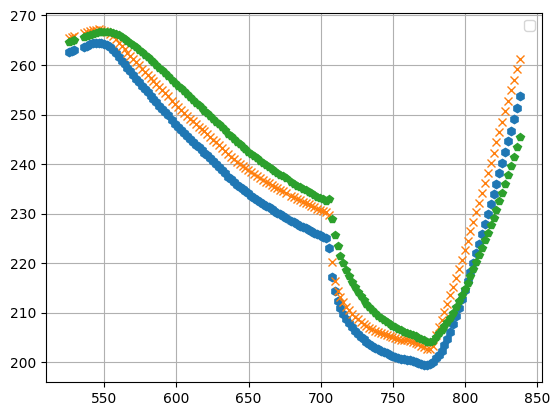

In [162]:
plt.errorbar(DF_Nov10["Time"][::60]/60.0,DF_Nov10["Xe_Cell_1"][::60], fmt="h")
plt.errorbar(DF_Nov10["Time"][::60]/60.0,DF_Nov10["Xe_Cell_2"][::60], fmt="x")
plt.errorbar(DF_Nov10["Time"][::60]/60.0,DF_Nov10["Xe_Cell_3"][::60], fmt="p")
plt.grid()
plt.legend()


In [144]:
DF_Nov10.keys()

Index(['Flow_Meter', 'Liquid_Nitro_Valve', 'PID_Heater', 'Pressure_Cell',
       'Pressure_Mfold', 'Pressure_Nitro', 'Heater_State', 'Nitro_Baseline',
       'Nitro_Weigth', 'Target_Channel', 'Target_Temperature', 'Time',
       'Valve_State', 'Cold_Finger', 'Nitro_Reservoir', 'Storage_1',
       'Storage_2', 'Xe_Cell_1', 'Xe_Cell_2', 'Xe_Cell_3', 'Xe_Cell_Outside'],
      dtype='object')